# 1. 安装依赖包，导入头文件

In [61]:
# 如果没有安装，解注释进行安装
# !pip install -r requirements.txt

## 请把下面解注释，安装finrl库
# 或者把如下Github仓中的finrl文件夹考到根目录即可使用
##!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# 强化学习库，使用stable_baselines3

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

In [63]:
from finrl import config  # 包含各类超参
from finrl import config_tickers  # 常见各类市场股票代码集合，比如中证300
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    # TRADE_START_DATE,
    # TRADE_END_DATE,
)
# 创建目录
check_and_make_directories([TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# 2. 查看和加载数据

In [64]:
# 读取训练数据，所有股票均混在了一个csv表里，格式如下
# 索引     日期          股票
#  0      2009-01-02    苹果
#  0      2009-01-02    亚马逊
#  1      2009-01-05    苹果
#  1      2009-01-05    亚马逊

# 注意：必须保持上述该格式，同样的索引下至少有2个数据，否则会报错，
# 原因：
#   1. 在finrl/meta/env_stock_trading/env_stocktrading.py的
#      _initiate_state函数中self.data.close.values.tolist()，
#      在404行，要求self.data.close必须是二维数组
#   2. 而finrl/meta/env_stock_trading/env_stocktrading.py的
#      __init__的64行self.data = self.df.loc[self.day, :]，
#      如果索引顺序排，0，1，2。。。，会导致只取到一个行数，一维
#      数据传入导致第1点中所述的问题
#      （因此，如果只有一支股票时，需要把索引全部改成一样的，当然
#      这种情况几乎不存在，也可以暂时忽略）
# 解决方法：
# 1. 降低numpy版本
# 2. 把数据改成二维的，即（10，）-》（1，10） （改完是否存在回测不完整性，没有详细验证）
# 3. 保持最上方所示的数据格式（推荐）

TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

processed_full = pd.read_csv(os.path.join(DATA_SAVE_DIR, 'full_data.csv'))

train = pd.read_csv(os.path.join(DATA_SAVE_DIR, 'train_data.csv'))
trade = pd.read_csv(os.path.join(DATA_SAVE_DIR, 'trade_data.csv'))

train = train.set_index(train.columns[0])
train.index.names = ['']
assert train.shape[0] > 1, '数据必须至少包含2行，即2天以上'

trade = trade.set_index(trade.columns[0]) # 第一列为索引
trade.index.names = ['']
assert trade.shape[0] > 1, '数据必须至少包含2行，即2天以上'

### 设置波动率阈值
- 设置波动率阈值 > 样本内波动最大值的日期。
- 如果当前的波动指数 > 阈值，我们认为当前市场波动性大

In [65]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])  # 去重，仅保留一支股票
pass

In [66]:
# 查看因子中的波动率 （vix是下载下来的数据）

# 波动率解释查看：https://spglobal.com/spdji/zh/vix-intro/

# 芝加哥期权交易所(Cboe) 波动率指数（简称VIX），用于预测美国股市在不久的将来可能高于
# 和低于其当前水平的波动范围。具体而言，VIX 衡量标普 500®指数 (SPX)未来 30 天的隐含波动率。
# 当隐含波动率处于高水平时，VIX数值会相应地提高，可能值范围亦较为宽阔。
# 当隐含波动率处于低水平时，则 VIX数值会相应降低，可能值范围亦较为狭窄。

# 由于股市最不稳定时VIX会升至最高水平，所以媒体倾向将 VIX称为恐慌指标。
# 这名称正好反映VIX如何衡量市场情绪，尤其是市场的担忧虑情绪。

insample_risk_indicator.vix.describe()

count    1654.000000
mean       16.473337
std         7.673456
min         9.140000
25%        12.420000
50%        14.210000
75%        17.565000
max        82.690002
Name: vix, dtype: float64

In [67]:
insample_risk_indicator.vix.quantile(0.996)

64.56692082214343

In [68]:
# 查看动荡指数 （通过finRL库进行计算得到）
# 参考资料：
#  https://portfoliooptimizer.io/blog/the-turbulence-index-measuring-financial-risk/
#  https://blog.csdn.net/weixin_38754123/article/details/124358040

# 动荡指数（The Turbulence Index）是衡量统计异常程度的指标，它既考虑了回报率的大小，
# 也考虑了它们之间的相互作用。

# 动荡指数量化了给定资产范围内异常行为的程度。其背后的解释是，资产回报率、
# 波动性和相关性，它们与历史正常状态的差异越大，就越有可能是某个重大市场事件造成的，
# 而不是随机噪声。

insample_risk_indicator.turbulence.describe()

count    1654.000000
mean       40.860017
std        51.973844
min         2.490455
25%        17.299122
50%        26.440174
75%        44.575623
max       652.507328
Name: turbulence, dtype: float64

In [69]:
# 分位数（Quantile），亦称分位点，是指将一个随机变量的概率分布范围分为几个等份的数值点，
# 常用的有中位数（即二分位数）、四分位数、百分位数等
insample_risk_indicator.turbulence.quantile(0.996)

426.47786559550553

# 3. 回测
## 3.1 强化学习回测

In [70]:
# 选择使用的强化学习策略
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

# 加载模型
trained_a2c = A2C.load(os.path.join(TRAINED_MODEL_DIR, 'a2c', "agent_a2c.zip")) if if_using_a2c else None
trained_ddpg = DDPG.load(os.path.join(TRAINED_MODEL_DIR, 'ddpg', "agent_ddpg.zip")) if if_using_ddpg else None
trained_ppo = PPO.load(os.path.join(TRAINED_MODEL_DIR, 'ppo', "agent_ppo.zip")) if if_using_ppo else None
trained_td3 = TD3.load(os.path.join(TRAINED_MODEL_DIR, 'td3', "agent_td3.zip")) if if_using_td3 else None
trained_sac = SAC.load(os.path.join(TRAINED_MODEL_DIR, 'sac', "agent_sac.zip")) if if_using_sac else None

D:\ProgramFiles\anaconda3\lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_make_function' on <module 'cloudpickle.cloudpickle' from 'D:\\ProgramFiles\\anaconda3\\lib\\site-packages\\cloudpickle\\cloudpickle.py'>
  warnings.warn(


交易（集外性能验证）
- 周期性更新以利用好数据，比如，每季度、每月、或每周重新训练模型，并进行调参优化
- 在这个notebook中，使用2009-01到2020-07的数据调参，因此一些因子随着时间衰减
- 大量的超参影响学习过程，同时决定了测试的性能

In [71]:
# 共29支股票，状态空间291
stock_dimension = len(trade.tic.unique())
# 状态说明
# 1：账户余额
# [1: stock_dimension+1]: 股票价格
# [stock_dimension+1: 1 + 2*stock_dimension]: 持仓数量
# len(INDICATORS)*stock_dimension：每支股票的因子状态，bool型表示
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [72]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension  # 交易手续费
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,  # actions initially is scaled between 0 to 1
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [73]:
# todo: ? 训练和测试不一致：测试中引入了波动率及阈值
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [74]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [75]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [76]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

In [77]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [78]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


## 3.2 对比基线：最大化均值方差

- 作者：Dr G A Vijayalakshmi Pai
- 参考代码：https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

最大化均值方差（Mean Variance optimization）是一个非常经典的投资组合管理策略。

In [79]:
# 处理mvo表
def process_df_for_mvo(df):
    df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
    fst = df
    fst = fst.iloc[0:stock_dimension, :]  # 取交易日第1天的29支股票
    tic = fst['tic'].tolist()  # 获取股票列表
    
    mvo = pd.DataFrame()
    
    # 初始化每个股票的mvo值为0
    for k in range(len(tic)):
        mvo[tic[k]] = 0
    
    # 按交易日，一天一天遍历，每次取29支股票
    # 生成列表，列是29值股票，行索引是日期，填充是收盘价
    for i in range(df.shape[0]//stock_dimension):
        n = df
        n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
        date = n['date'][i*stock_dimension]
        mvo.loc[date] = n['close'].tolist()
    
    return mvo


# 平均收益率与方差-协方差矩阵
def StockReturnsComputing(StockPrice, Rows, Columns): 
    import numpy as np 
    StockReturn = np.zeros([Rows-1, Columns]) 
    for j in range(Columns):        # j: Assets 
        for i in range(Rows-1):     # i: Daily Prices 
            # 通过前后2天的差值计算收益
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
    return StockReturn

In [80]:
# 计算均值方差权重
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()  # 即取消表头和索引


array([[ 89.495, 236.683,  91.078, ...,  47.767,  36.77 , 115.097],
       [ 89.495, 239.578,  91.35 , ...,  47.872,  37.76 , 114.636],
       [ 91.889, 237.732,  93.529, ...,  48.265,  38.821, 114.328],
       ...,
       [147.342, 199.597, 179.354, ...,  49.08 ,  46.593, 147.145],
       [148.016, 200.606, 178.016, ...,  49.546,  45.732, 145.861],
       [147.55 , 198.588, 175.143, ...,  49.126,  44.605, 144.664]])

In [81]:
# 计算资产收益
arStockPrices = np.asarray(StockData)  # 维度（2893， 29）
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)  # 维度（2893， 29）

# 计算平均收益和收益的方差-协方差矩阵
meanReturns = np.mean(arReturns, axis = 0)   # 维度（29）
covReturns = np.cov(arReturns, rowvar=False)  # 维度（29， 29）
 
# 设置打印保留的精度
np.set_printoptions(precision=3, suppress = True)

# 显示平均收益和收益的方差-协方差矩阵
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

使用 PyPortfolioOpt

PyPortfolioOpt是一个实现投资组合优化方法的库，其中包括经典的均值方差优化技术和Black-Litterman
资产配置模型，以及该领域的最新进展，例如收缩率shrinkage和层次风险平价模型
Hierarchical Risk Parity，以及一些新颖的实验功能，例如指数加权协方差矩阵。

马科维兹有效前沿(efficient_frontier)

有效前沿亦称“有效边界”。理性的投资者一般是厌恶风险而偏好收益的，
对于相同的风险水平，会选择能提供最大收益率的组合；对于相同的预期收益率，
会选择风险最小的组合。能同时满足这些条件的投资组合就是有效前沿。

“现代投资组合理论”（MPT）是1952年哈里.马克维茨在金融期刊上发表的名为
“Portfolio Selection”的文章上提出的投资理论。

虽然在一个投资组合的收益为所有股票收益的平均值/加权平均值，
但这个投资组合的风险不等于投资组合里所有股票风险的平均值/加权平均值。
风险就是指一个资产的变化情况，如果在你的投资组合里有多只股票，
那么你就需要计算一下这些股票之间变化的相关性。多样性的好处在于，
你可以通过优化资产配置，使得该投资组合的风险低于投资组合中风险最低的股票的风险。


参考：https://blog.csdn.net/jirox/article/details/116406486

In [82]:
from pypfopt.efficient_frontier import EfficientFrontier

# 计算马科维兹有效前沿，获取最大化均值方差
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
# 初始资金乘以权重
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([424250.,      0.,      0.,      0.,      0., 108650.,      0.,
            0.,      0.,      0., 181450.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  16960.,
            0.,      0.,      0., 133540., 135150.,      0.,      0.,
            0.])

In [83]:
# 通过资金分配除以最后交易日的价格，获取初始持仓组合
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4731.544,    0.   ,    0.   ,    0.   ,    0.   ,  579.993,
          0.   ,    0.   ,    0.   ,    0.   ,  766.21 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   85.251,    0.   ,    0.   ,    0.   ,
        468.596,  712.801,    0.   ,    0.   ,    0.   ])

In [84]:
# 它与numpy.dot（）的作用是一样的，矩阵乘法
Portfolio_Assets = TradeData @ Initial_Portfolio
# 获取每一交易日的总投资组合资产
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2020-07-01,1.001917e+06
2020-07-02,1.004234e+06
2020-07-06,1.023225e+06
2020-07-07,1.014021e+06
2020-07-08,1.029461e+06
...,...
2021-10-21,1.533022e+06
2021-10-22,1.535667e+06
2021-10-25,1.542077e+06
2021-10-26,1.545514e+06


## 3.3: 道琼斯指数(DJIA index)下载

In [85]:
# 由于国内无法使用YahooDownloader，暂时注释如下部分
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# df_dji = YahooDownloader(start_date = TRADE_START_DATE,
#                      end_date = TRADE_END_DATE,
#                      ticker_list = ['dji']).fetch_data()
# 
# df_dji

In [86]:
# df_dji = df_dji[['date','close']]
# fst_day = df_dji['close'][0]
# dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000), 
#                how='outer', left_index=True, right_index=True).set_index('date')
# dji


<a id='6'></a>
# 4. 性能对比

## 4.1 对比基线和强化学习

使用Quantopian pyfolio工具进行回测
 

In [87]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# 将强化学习和最大化均值方差结果合入一个表，进行对比
result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [88]:
# 修改列名
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
# col_name.append('djia') 
result.columns = col_name

In [89]:
result

,A2C,SAC,Mean Var
date,,,
2020-07-01,1.000000e+06,1.000000e+06,1.001917e+06
2020-07-02,1.000943e+06,1.000534e+06,1.004234e+06
2020-07-06,1.006884e+06,1.006289e+06,1.023225e+06
2020-07-07,9.960292e+05,9.979052e+05,1.014021e+06
2020-07-08,1.001440e+06,1.001714e+06,1.029461e+06
...,...,...,...
2021-10-21,1.771517e+06,1.316362e+06,1.533022e+06
2021-10-22,1.778274e+06,1.320957e+06,1.535667e+06
2021-10-25,1.779493e+06,1.327333e+06,1.542077e+06


<AxesSubplot:xlabel='date'>

<Figure size 1080x360 with 0 Axes>

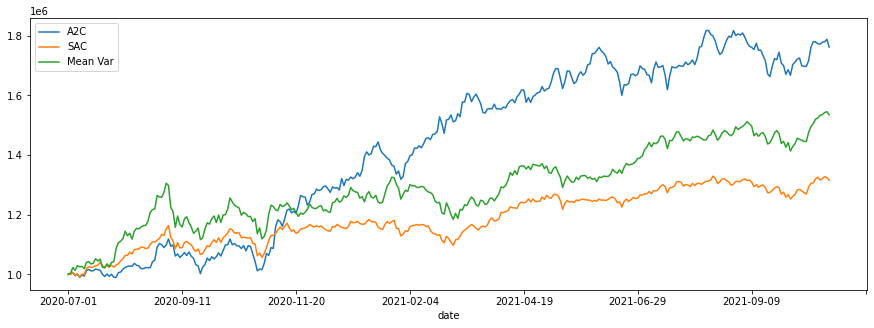

In [90]:
# 绘图对比总资产变化
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

## 4.2 计算详细回测指标

In [103]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

if if_using_ddpg:
  print("\n ddpg:")
  perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
  perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
  perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

if if_using_a2c:
  print("\n a2c:")
  perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
  perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
  perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

if if_using_td3:
  print("\n atd3:")
  perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
  perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
  perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

if if_using_sac:
  print("\n sac:")
  perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
  perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
  perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')
  

==============Get Backtest Results===========

 a2c:
Annual return          0.531267
Cumulative returns     0.761977
Annual volatility      0.207082
Sharpe ratio           2.168219
Calmar ratio           5.108832
Stability              0.913644
Max drawdown          -0.103990
Omega ratio            1.434179
Sortino ratio          3.603966
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.140148
Daily value at risk   -0.024308
dtype: float64

 sac:
Annual return          0.229471
Cumulative returns     0.316038
Annual volatility      0.135545
Sharpe ratio           1.597028
Calmar ratio           2.503250
Stability              0.885632
Max drawdown          -0.091669
Omega ratio            1.300750
Sortino ratio          2.291562
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.029162
Daily value at risk   -0.016218
dtype: float64


D:\ProgramFiles\anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
D:\ProgramFiles\anaconda3\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [96]:
# 由于无法下载道尔琼斯指数，暂时注释掉了如下代码
#baseline stats
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#              baseline_ticker = '^DJI', 
#              baseline_start = df_account_value.loc[0,'date'],
#              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

## 4.3 回测绘图

In [96]:
# 由于无法下载道尔琼斯指数，暂时注释掉了如下代码
# 获取详细和指数进行的统计对比报表以及分析图

# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# 
# if if_using_ppo:
#   backtest_plot(df_account_value_ppo, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)
# 
# if if_using_ddpg:
#   backtest_plot(df_account_value_ddpg, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)
# 
# if if_using_a2c:
#   backtest_plot(df_account_value_a2c, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)
# 
# if if_using_td3:
#   backtest_plot(df_account_value_td3, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)
# 
# if if_using_sac:
#   backtest_plot(df_account_value_sac, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)
